#Understanding and Implementing K-Means, Hierarchical, and DBSCAN Algorithms

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

In [2]:
data=pd.read_csv("/content/drive/MyDrive/Assignments/Clustering/EastWestAirlines.csv")
data.head()

,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
0,1,28143,0,1,1,1,174,1,0,0,7000,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1


In [3]:
# Finding the information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   ID#                3999 non-null   int64
 1   Balance            3999 non-null   int64
 2   Qual_miles         3999 non-null   int64
 3   cc1_miles          3999 non-null   int64
 4   cc2_miles          3999 non-null   int64
 5   cc3_miles          3999 non-null   int64
 6   Bonus_miles        3999 non-null   int64
 7   Bonus_trans        3999 non-null   int64
 8   Flight_miles_12mo  3999 non-null   int64
 9   Flight_trans_12    3999 non-null   int64
 10  Days_since_enroll  3999 non-null   int64
 11  Award?             3999 non-null   int64
dtypes: int64(12)
memory usage: 375.0 KB


- ID		Unique ID

- Balance		number of miles eligible for award travel

- Qual_miles	number of miles counted as qualifying for top flight status

- cc1_miles	number of miles earned with freq flyer credit cars in past 12 months

- cc2_miles	number of miles earned with rewards credit card in past 12 months

- cc3_miles	number of miles earned with small business credit card in 12 mnths

miles_bins:
- 1=under 5000
- 2=5000-10000
- 3=10001-25000
- 4=25001-50000
- 5= over 50000

- Bonus_miles	number of miles earned from non flight bonus transactions in past 12 months

- bonus_trans	number of non flight bonus transactions in past 12 months

- flight miles 12 mo	number of flight miles in past 12 months

- flight trans_12 mo	number of flight transactions in the past 12 months

- days_since_enroll	number of days since enroll date

- award?			dummy variable for the Last Award [1= not null awards, 0= null awards]

we can change the names of the attributes and remove extra suffixes to it, as what ever calculated is done for the past 12 months   

In [4]:
df=data.copy()
df.head(1)

,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
0,1,28143,0,1,1,1,174,1,0,0,7000,0


In [5]:
# Renaming some attributes
df.rename(columns={"Flight_miles_12mo": "flight_miles"}, inplace=True)
df.rename(columns={"Flight_trans_12": "flight_trans"}, inplace=True)
df.head()

,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,flight_miles,flight_trans,Days_since_enroll,Award?
0,1,28143,0,1,1,1,174,1,0,0,7000,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1


In [6]:
df[df.duplicated(keep=False)]

,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,flight_miles,flight_trans,Days_since_enroll,Award?


In [7]:
#There are no duplicate values in the dataset
#lets drop the unnecessary columns and i.e. is ID
airlines=df.drop(columns="ID#",axis=1)
airlines.head()

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,flight_miles,flight_trans,Days_since_enroll,Award?
0,28143,0,1,1,1,174,1,0,0,7000,0
1,19244,0,1,1,1,215,2,0,0,6968,0
2,41354,0,1,1,1,4123,4,0,0,7034,0
3,14776,0,1,1,1,500,1,0,0,6952,0
4,97752,0,4,1,1,43300,26,2077,4,6935,1


In [8]:
#There are No Null Values in the entire dataset
airlines.describe()

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,flight_miles,flight_trans,Days_since_enroll,Award?
count,3.999000e+03,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.00000,3999.000000,3999.000000,3999.00000,3999.000000
mean,7.360133e+04,144.114529,2.059515,1.014504,1.012253,17144.846212,11.60190,460.055764,1.373593,4118.55939,0.370343
std,1.007757e+05,773.663804,1.376919,0.147650,0.195241,24150.967826,9.60381,1400.209171,3.793172,2065.13454,0.482957
min,0.000000e+00,0.000000,1.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,2.00000,0.000000
25%,1.852750e+04,0.000000,1.000000,1.000000,1.000000,1250.000000,3.00000,0.000000,0.000000,2330.00000,0.000000
50%,4.309700e+04,0.000000,1.000000,1.000000,1.000000,7171.000000,12.00000,0.000000,0.000000,4096.00000,0.000000
75%,9.240400e+04,0.000000,3.000000,1.000000,1.000000,23800.500000,17.00000,311.000000,1.000000,5790.50000,1.000000
max,1.704838e+06,11148.000000,5.000000,3.000000,5.000000,263685.000000,86.00000,30817.000000,53.000000,8296.00000,1.000000


we can get some inferences from here such as
- on an average there are people who travelled between 5000-10000 miles with frequent flyer credut card
- on an average there are people who travel under 5000 miles with reward credit cards
-  on an average there are people who travel under 5000 miles with small business credit cards
- and only 37 percent of people have gotten their last award


## histogram visulization

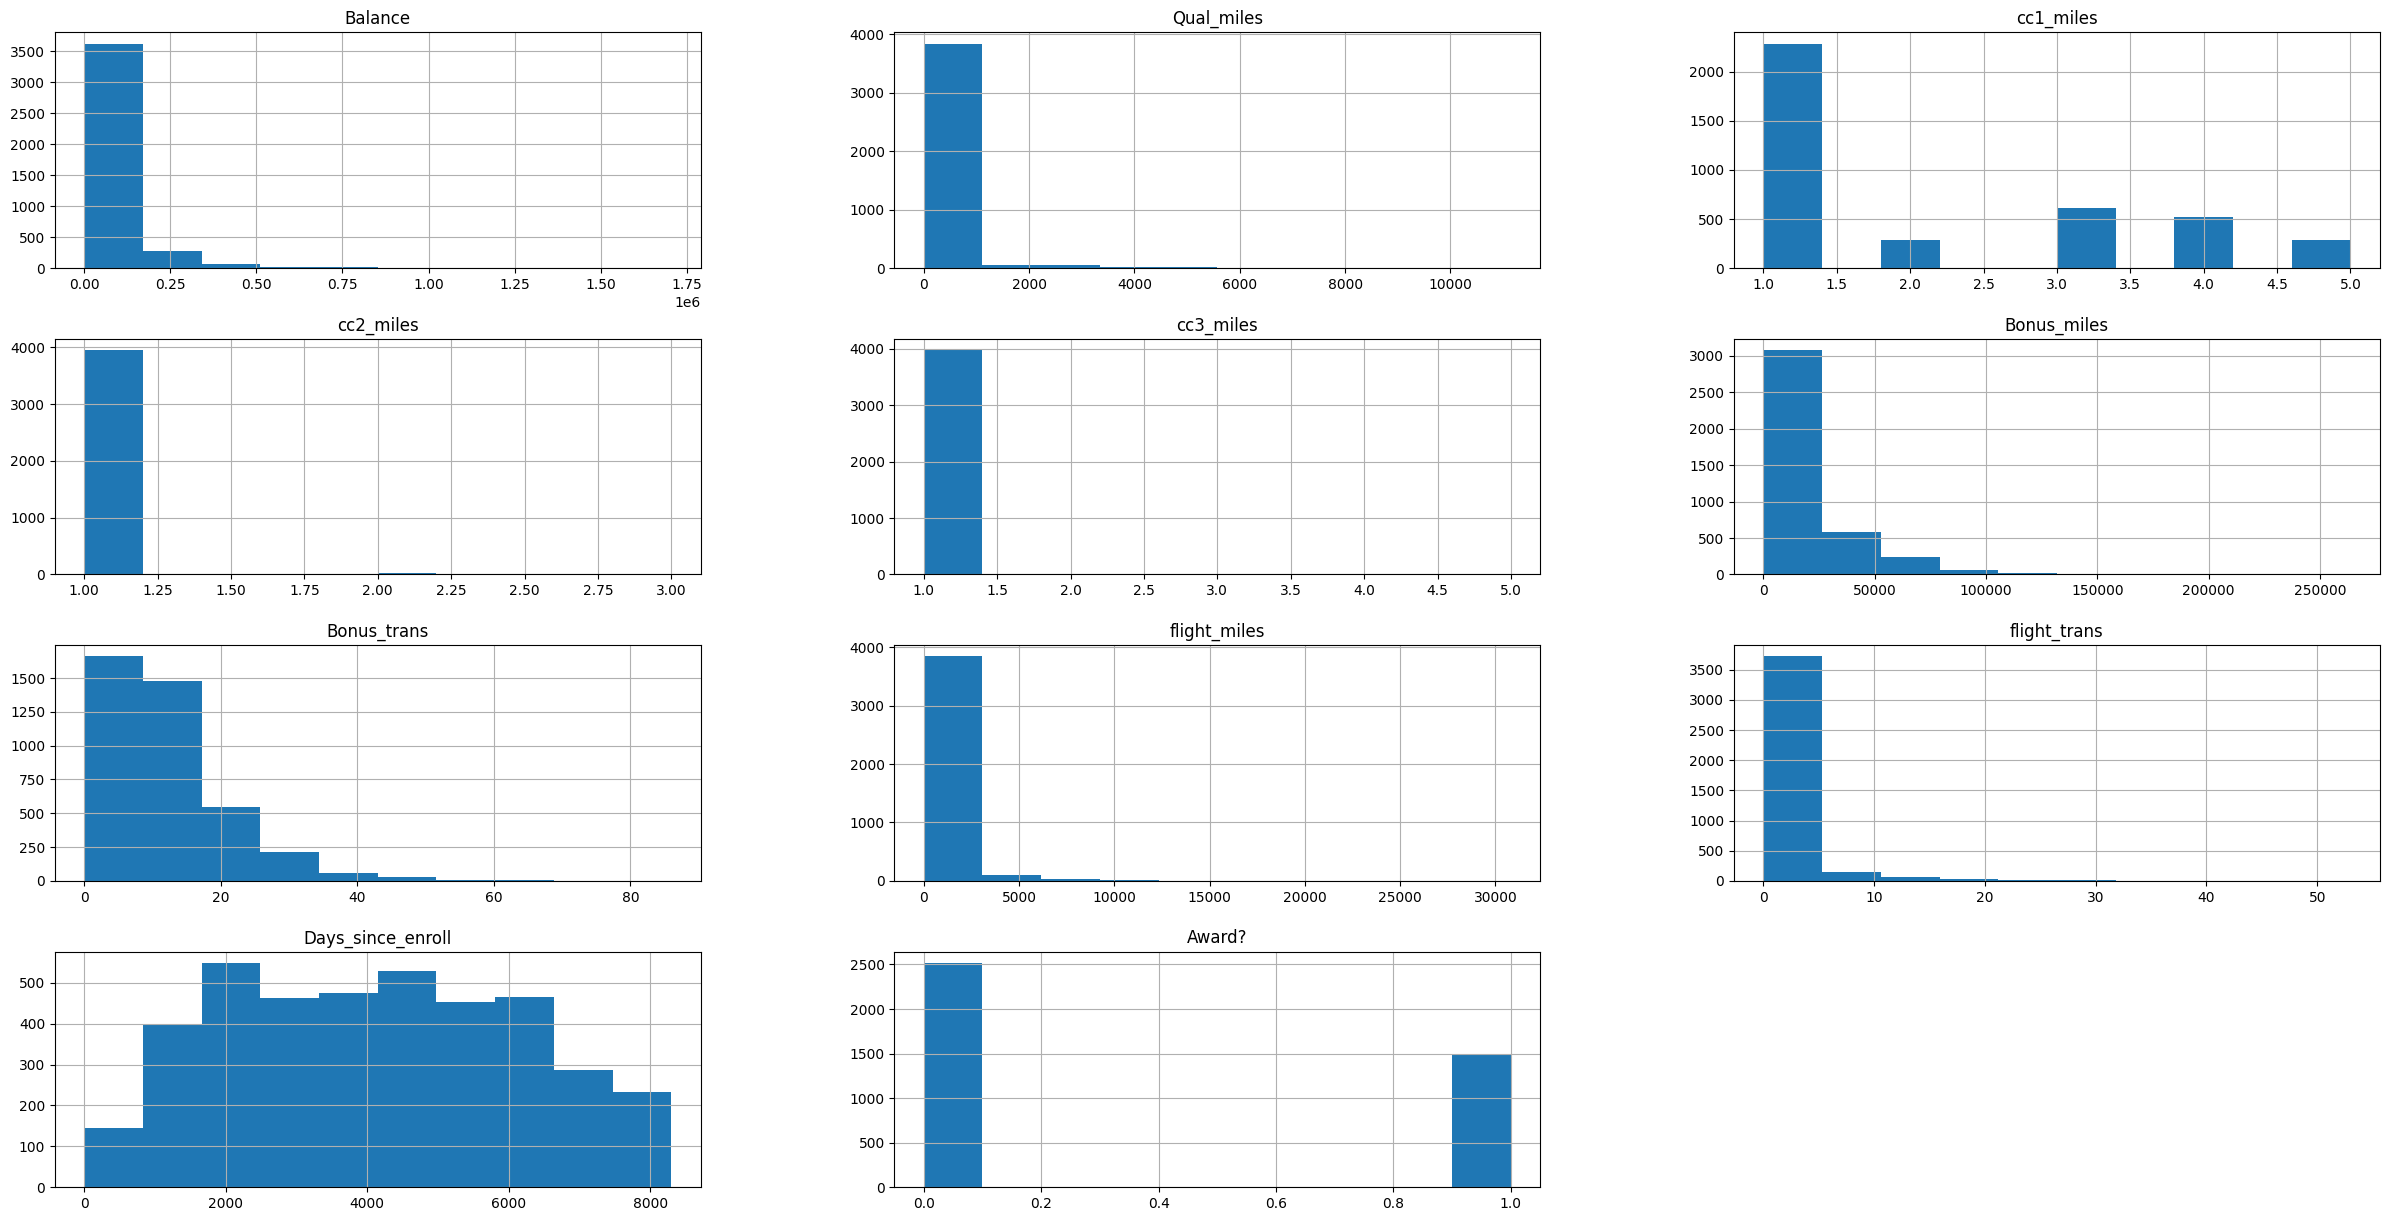

In [119]:
airlines.hist(figsize=(30,15))
plt.show()

### histogram with kde visualization

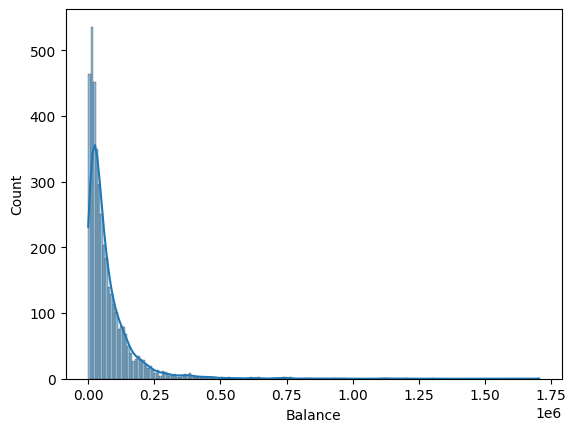

In [120]:
sns.histplot(airlines["Balance"],kde=True)
plt.show()

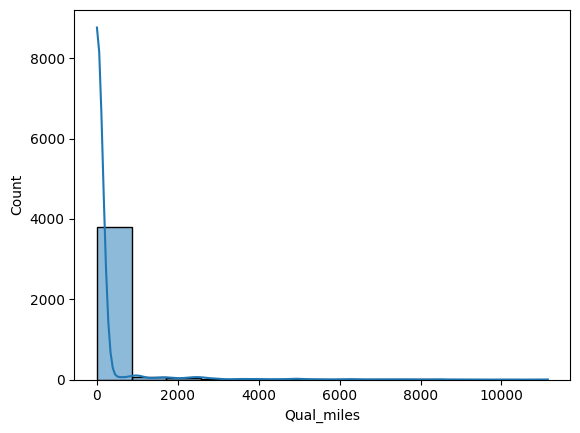

In [121]:
sns.histplot(airlines["Qual_miles"],kde=True)
plt.show()

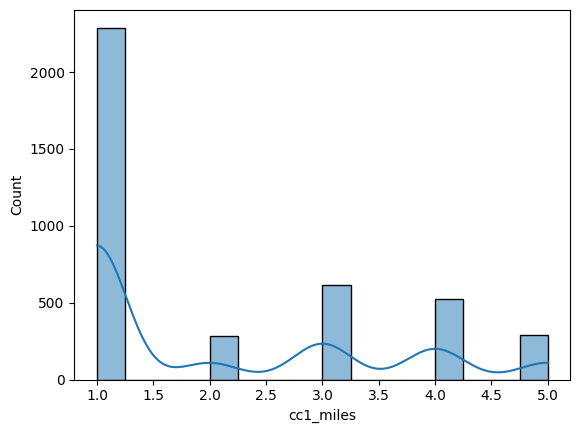

In [122]:
sns.histplot(airlines["cc1_miles"],kde=True)
plt.show()

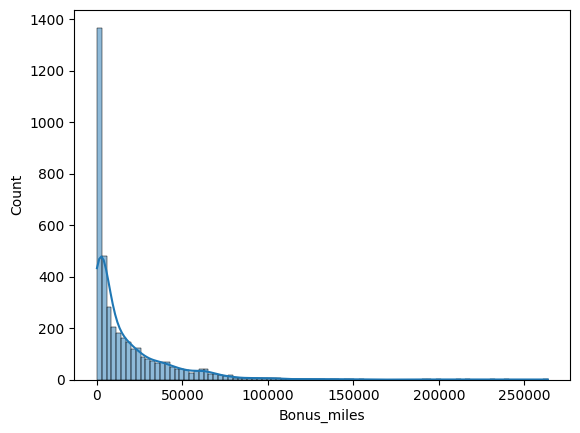

In [123]:
sns.histplot(airlines["Bonus_miles"],kde=True)
plt.show()

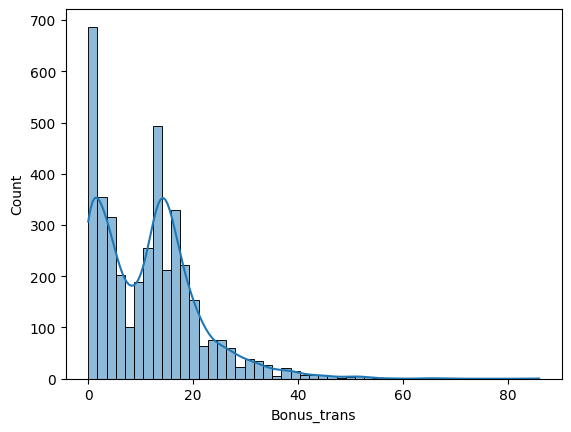

In [124]:
sns.histplot(airlines["Bonus_trans"],kde=True)
plt.show()

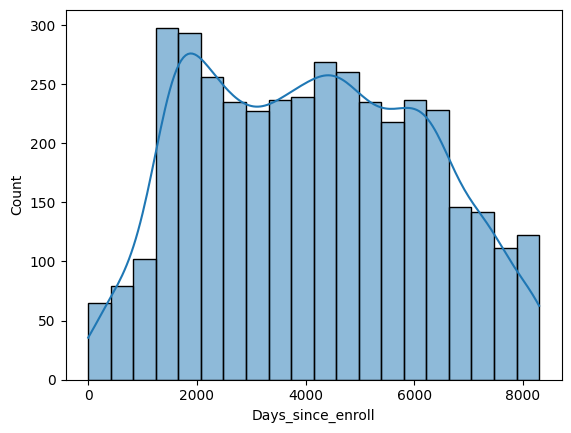

In [125]:
sns.histplot(airlines["Days_since_enroll"],kde=True)
plt.show()

##Boxplot visualization

<Axes: >

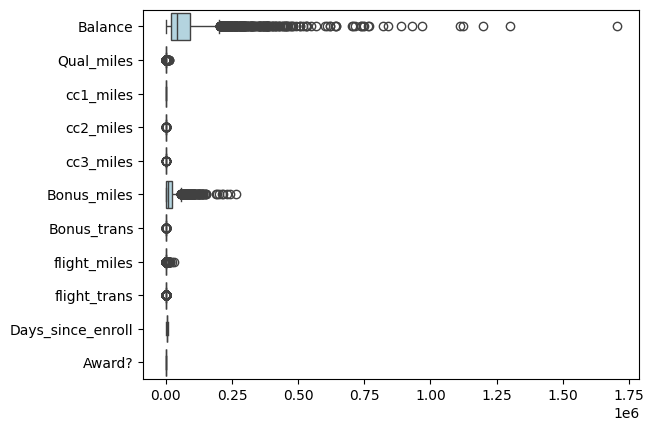

In [9]:
sns.boxplot(data=airlines, orient="h", color="lightblue")

# Overlay a swarm plot


In [127]:
#sns.swarmplot(data=data, orient="h", color="darkblue")

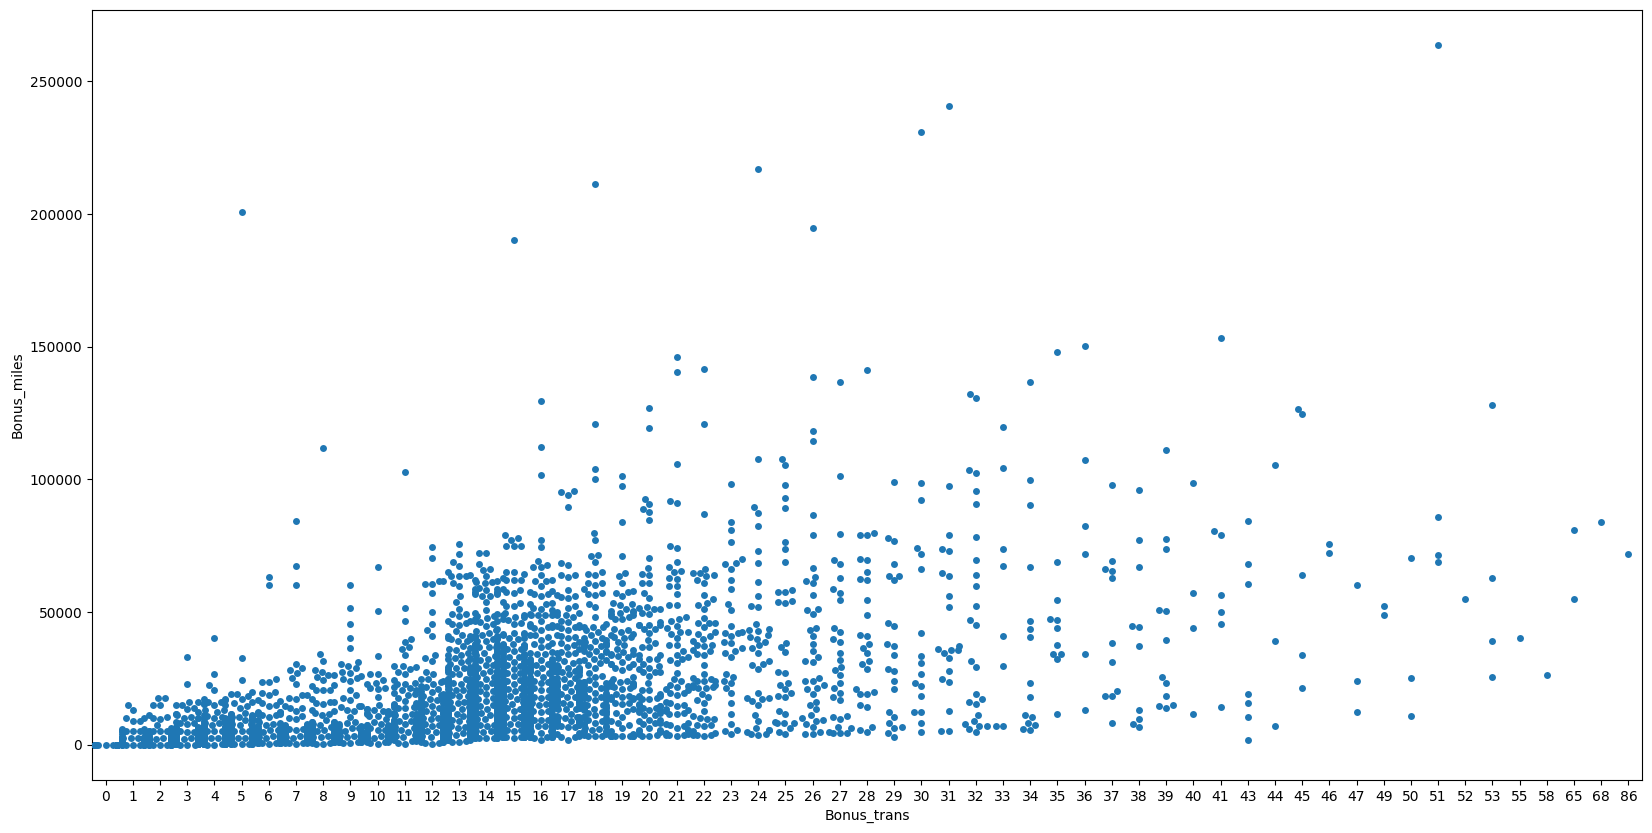

In [128]:
import warnings
warnings.filterwarnings("ignore") #just to ignore any warnings
plt.figure(figsize=(20,10))
sns.swarmplot(x="Bonus_trans",y="Bonus_miles",data=airlines)
plt.show()

### HeatMap visualization

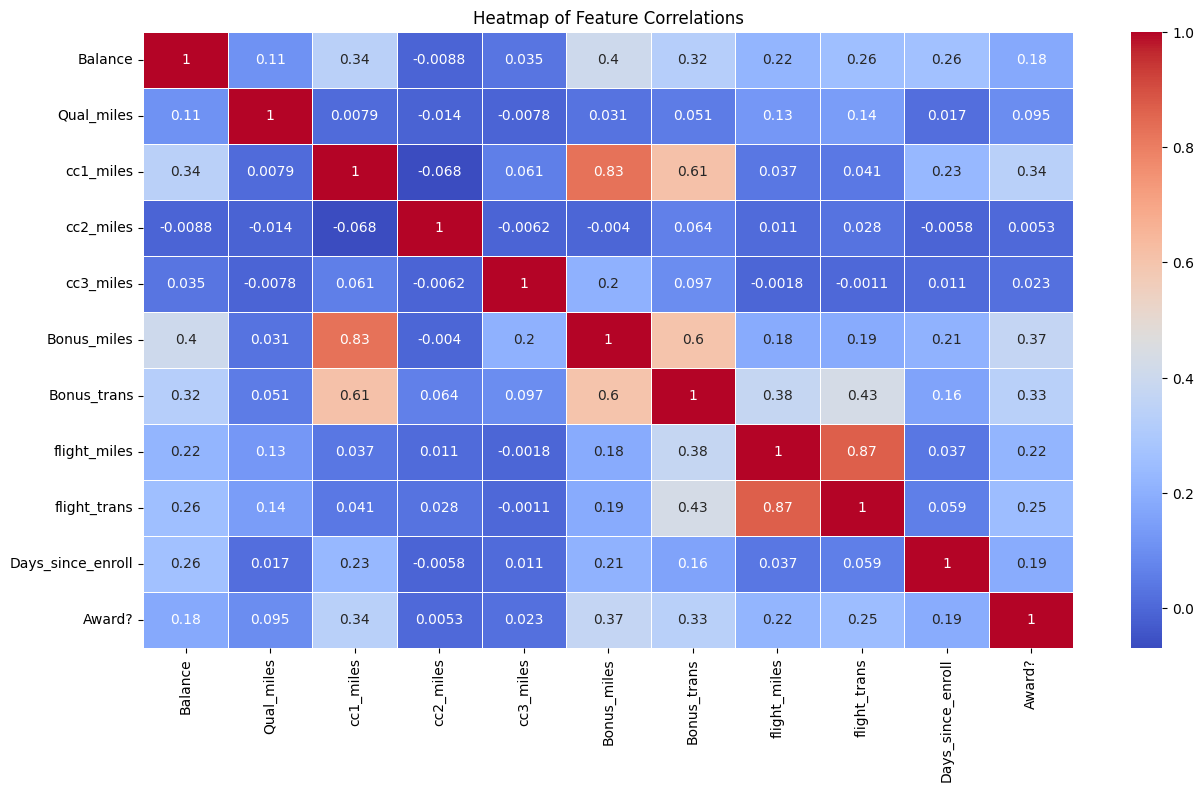

In [10]:
#Heat_map_Visualization
correlation_matrix = airlines.corr()

# Create the heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Feature Correlations')
plt.show()

#deals with the correlation values of the attributes of the dataset

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(airlines)
df_scaled = pd.DataFrame(scaled_features, columns=airlines.columns)
df_scaled.head()

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,flight_miles,flight_trans,Days_since_enroll,Award?
0,-0.451141,-0.186299,-0.769578,-0.098242,-0.062767,-0.702786,-1.104065,-0.328603,-0.362168,1.395454,-0.766919
1,-0.539457,-0.186299,-0.769578,-0.098242,-0.062767,-0.701088,-0.999926,-0.328603,-0.362168,1.379957,-0.766919
2,-0.320031,-0.186299,-0.769578,-0.098242,-0.062767,-0.539253,-0.791649,-0.328603,-0.362168,1.411920,-0.766919
3,-0.583799,-0.186299,-0.769578,-0.098242,-0.062767,-0.689286,-1.104065,-0.328603,-0.362168,1.372208,-0.766919
4,0.239678,-0.186299,1.409471,-0.098242,-0.062767,1.083121,1.499394,1.154932,0.692490,1.363975,1.303918


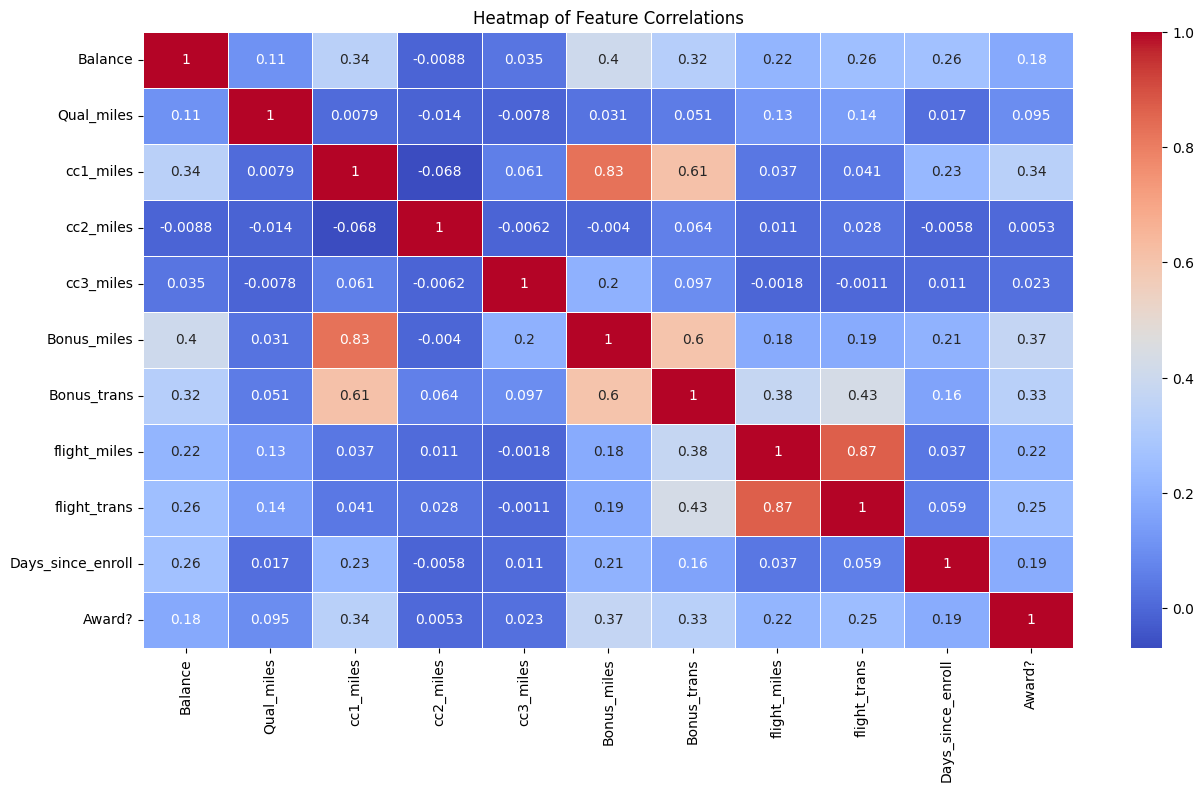

In [12]:
correlation_matrix = df_scaled.corr()

# Create the heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Feature Correlations')
plt.show()

- The heatmap represents the correlation coefficients between pairs of features.
- Values close to 1 (red) indicate a strong positive correlation, while values close to -1 (blue) indicate a strong negative correlation.
- Values around 0 indicate little to no correlation.


From your heatmap:

- cc1_miles is highly correlated with Bonus_miles (0.83) and Bonus_trans (0.61).
- flight_miles is highly correlated with flight_trans (0.87).

### pairplot visualization

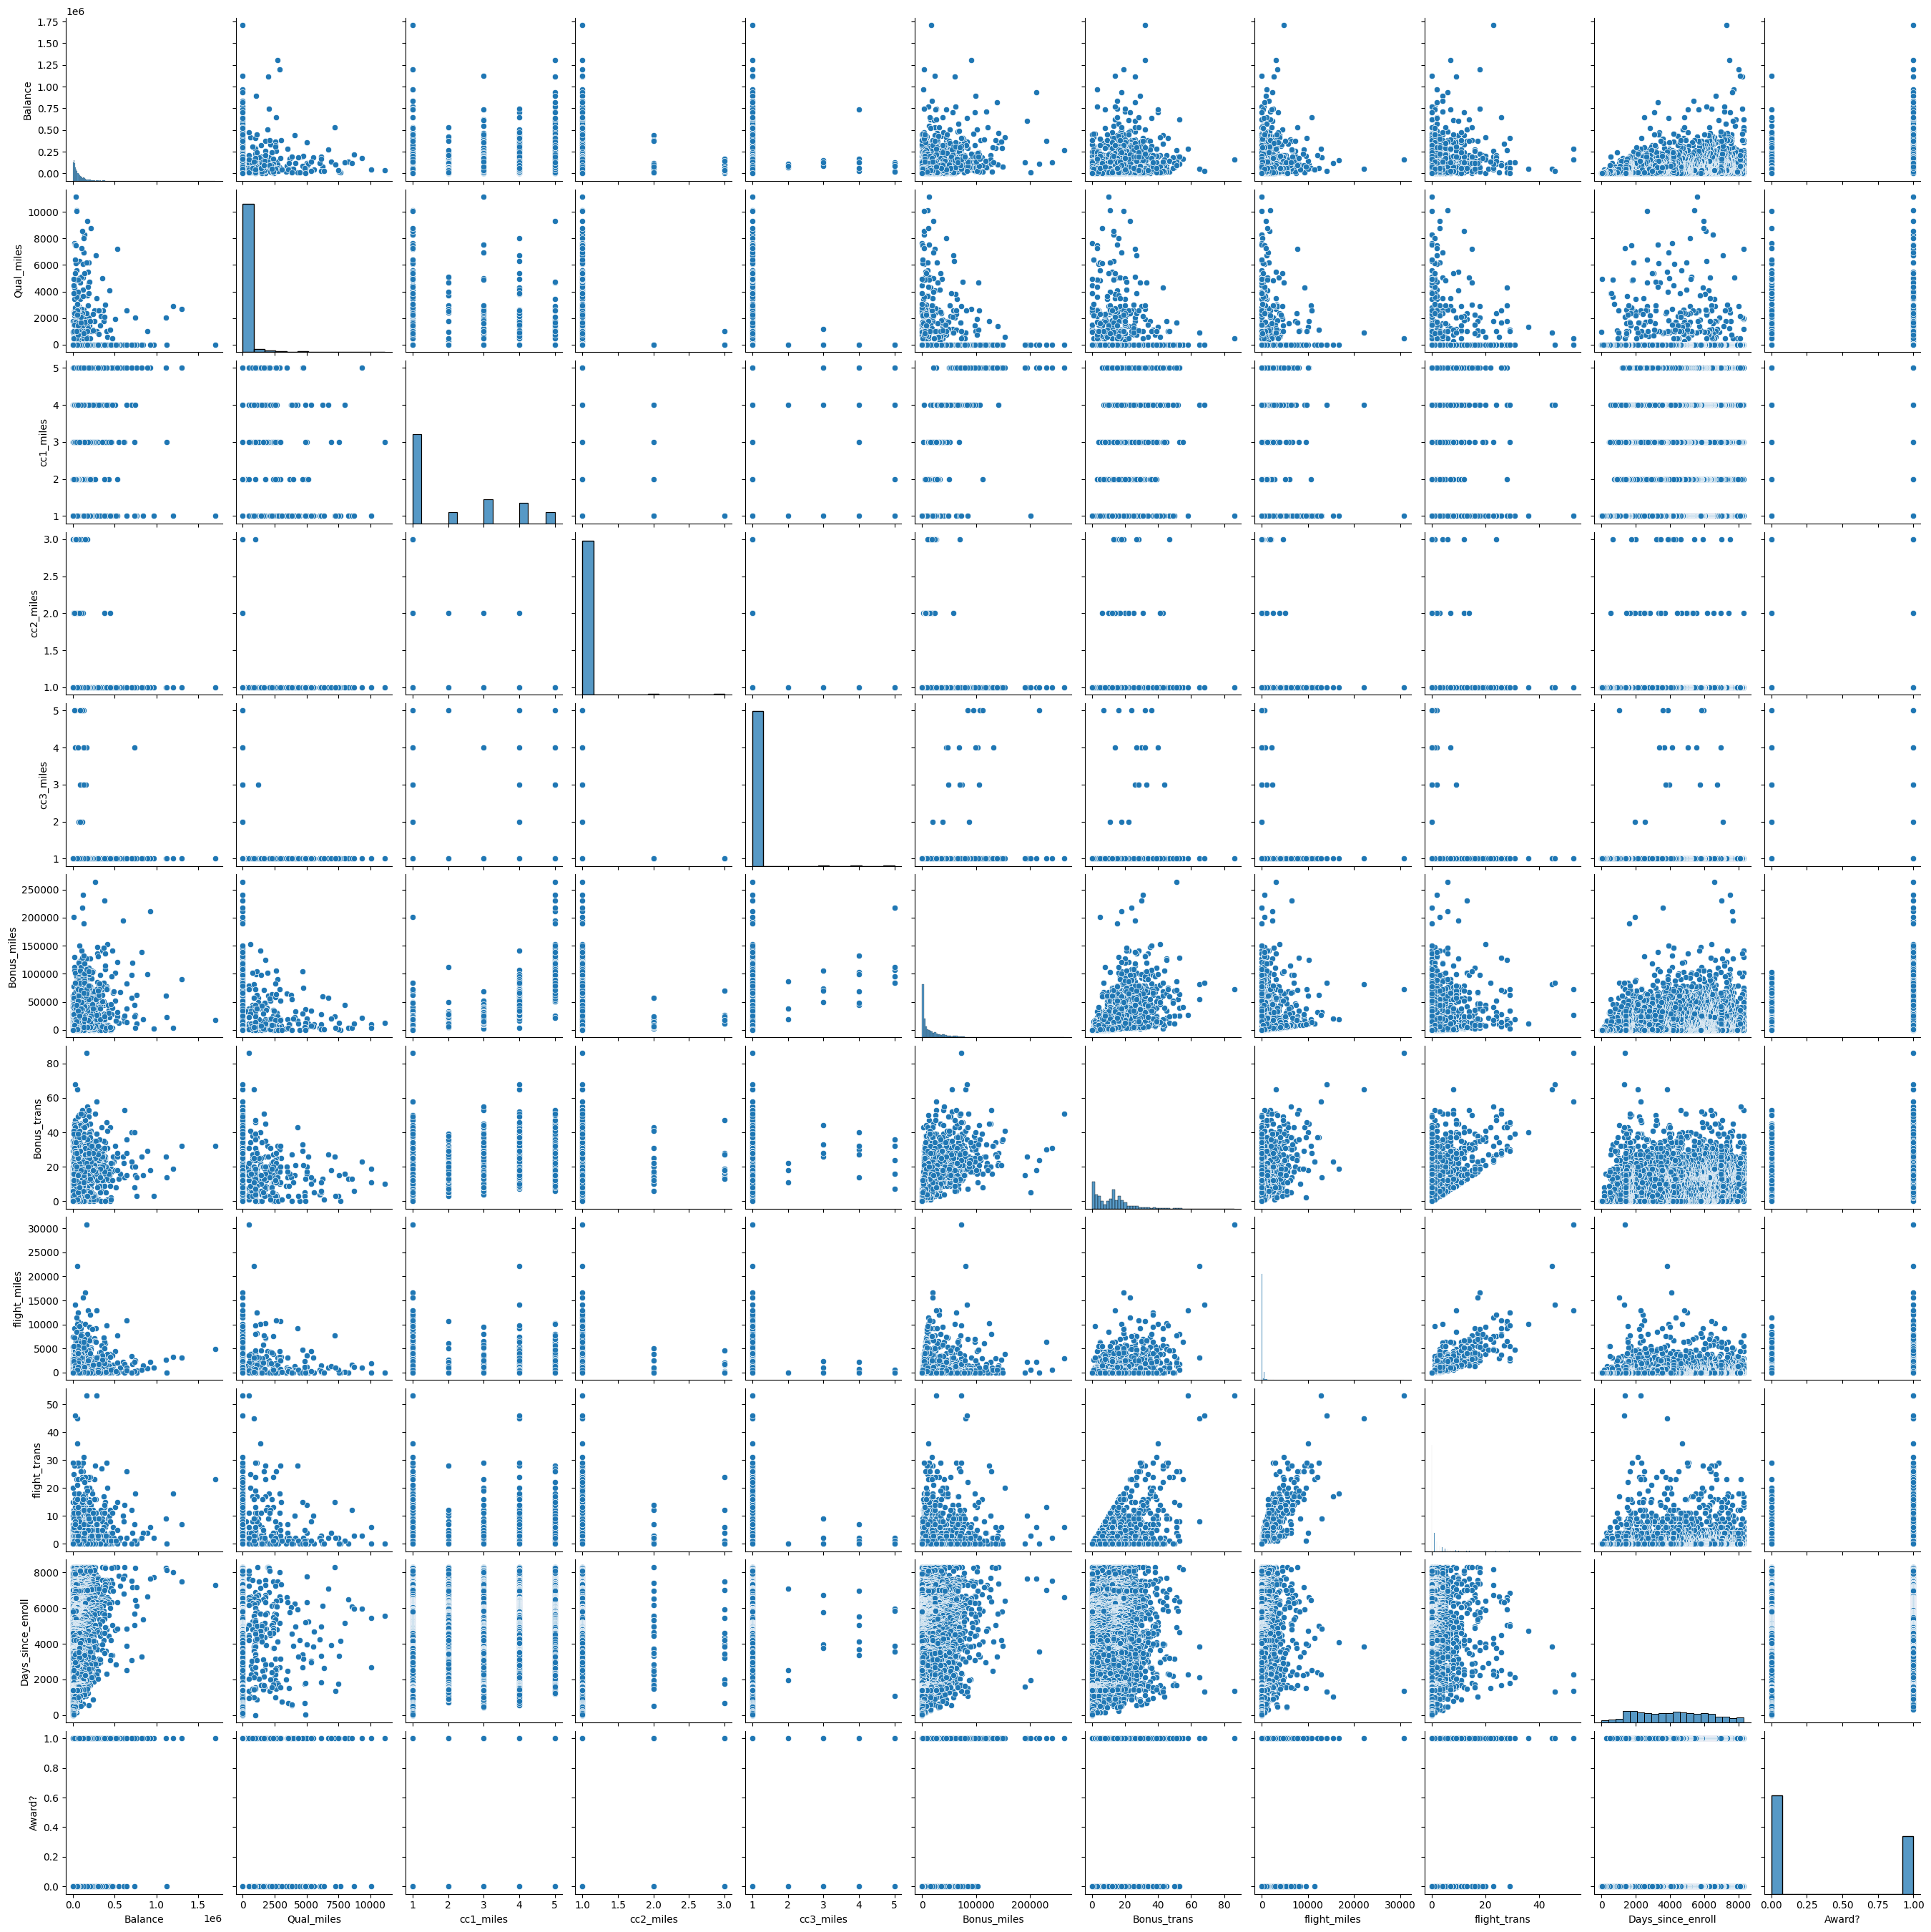

In [132]:
sns.pairplot(airlines)

In [13]:
# here we have no null values so lets find out the influentila observations and remove them
# Calculate the Z-scores
z_scores = np.abs(df_scaled)

# Define a threshold for Z-scores (e.g., 3 standard deviations)
threshold = 3
filtered_entries = (z_scores < threshold).all(axis=1)

# Filter the original DataFrame based on the calculated Z-scores
df_filtered = df[filtered_entries]

# Display the filtered dataset info and first few rows
df_new= df_filtered.drop(columns="ID#",axis=1)
print(df_new.head())
print(df_new.info())

   Balance  Qual_miles  cc1_miles  cc2_miles  cc3_miles  Bonus_miles  \
0    28143           0          1          1          1          174   
1    19244           0          1          1          1          215   
2    41354           0          1          1          1         4123   
3    14776           0          1          1          1          500   
4    97752           0          4          1          1        43300   

   Bonus_trans  flight_miles  flight_trans  Days_since_enroll  Award?  
0            1             0             0               7000       0  
1            2             0             0               6968       0  
2            4             0             0               7034       0  
3            1             0             0               6952       0  
4           26          2077             4               6935       1  
<class 'pandas.core.frame.DataFrame'>
Index: 3630 entries, 0 to 3998
Data columns (total 11 columns):
 #   Column             Non-Null 

- so the prominent outliers were removed using z score method
## Steps to Remove Outliers Using Z-Score
- Calculate the mean and standard deviation of the dataset.
- Compute the Z-score for each data point.
- Set a threshold for the Z-score. Common choices are 2, 2.5, or 3, depending on how strictly you want to define outliers.
- Filter out data points that have a Z-score beyond the threshold.

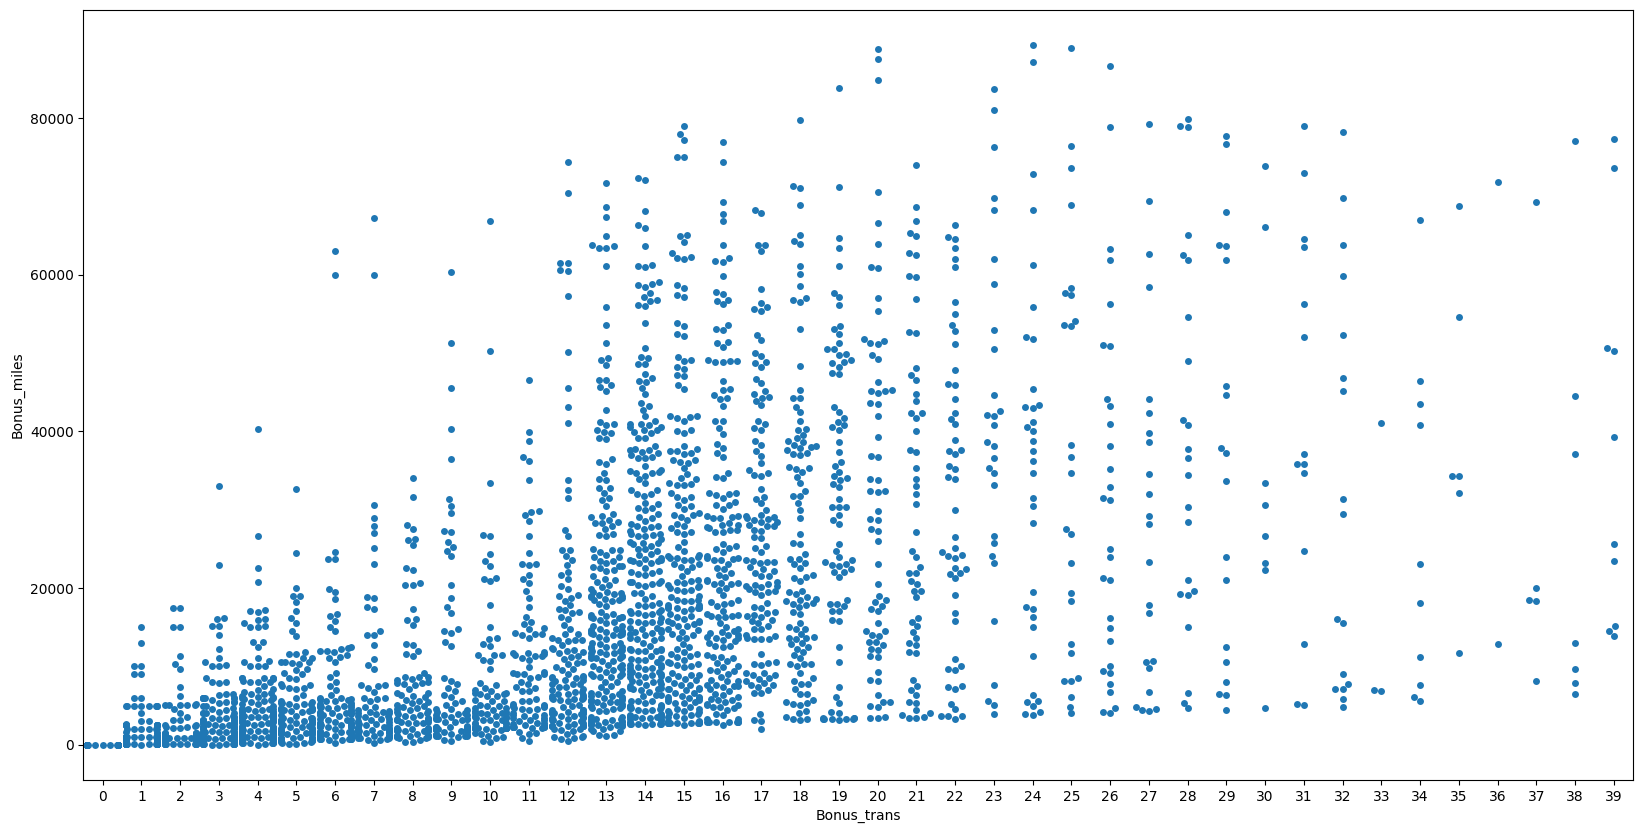

In [14]:
import warnings
warnings.filterwarnings("ignore") #just to ignore any warnings
plt.figure(figsize=(20,10))
sns.swarmplot(x="Bonus_trans",y="Bonus_miles",data=df_new)
plt.show()

so most of the outliers being removed gave us a more clear swarmplot and can visually see the clusters ,but how many are there is yet to be defined

## K-MEANS CLUSTERING


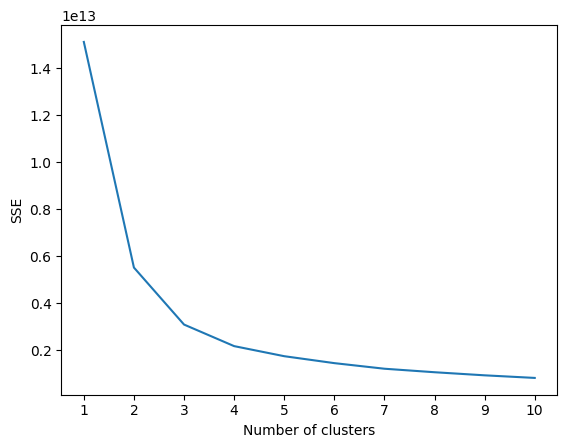

In [15]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Elbow Method
a = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=15)
    kmeans.fit(df_new)
    a.append(kmeans.inertia_)

plt.plot(range(1, 11), a)
plt.xticks(range(1, 11))
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()



- So as per the elbow method we can say that, the data can be clustered into minimum 2 clusters or maximum 3
- Here for more evaluation of the data let's consider the maximum clusters that can be formed and i.e., 3 clusters
- Now we will add the clusters numbers to the dataset so that we can identify the cluster per entry and can be usefull for future application development-

In [16]:
# K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=15)
df_new['KMeans_Labels'] = kmeans.fit_predict(df_new)


In [17]:
df_new.head(5)

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,flight_miles,flight_trans,Days_since_enroll,Award?,KMeans_Labels
0,28143,0,1,1,1,174,1,0,0,7000,0,1
1,19244,0,1,1,1,215,2,0,0,6968,0,1
2,41354,0,1,1,1,4123,4,0,0,7034,0,1
3,14776,0,1,1,1,500,1,0,0,6952,0,1
4,97752,0,4,1,1,43300,26,2077,4,6935,1,0


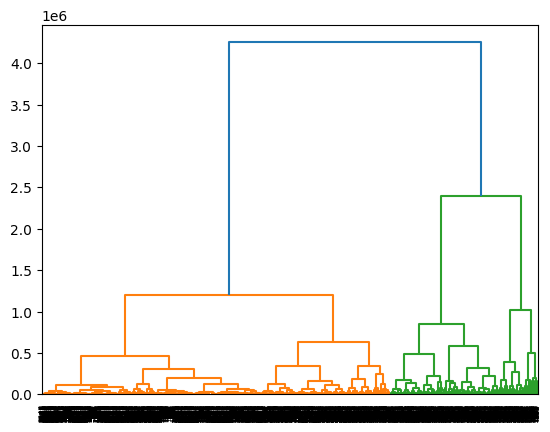

In [19]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

# Dendrogram
linked = linkage(df_new, method='ward')
dendrogram(linked)
plt.show()

# linkage have different method to go on with , ward is one of the methods, there are other methods such as single, complete, average,centroid, median, weighted average

- using the ward linkage , the dendogram formed 2 clusters

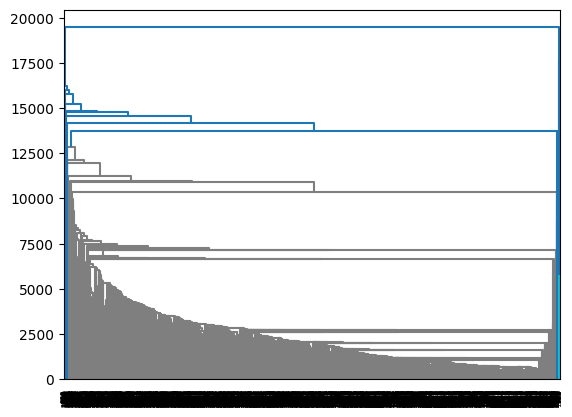

In [ ]:
#using single method
linked1 = linkage(df_new, method='single')
dendrogram(linked1)
plt.show()

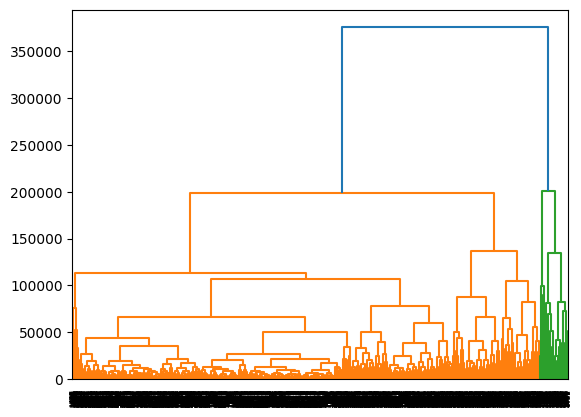

In [20]:
linked2 = linkage(df_new, method='complete')
dendrogram(linked2)
plt.show()

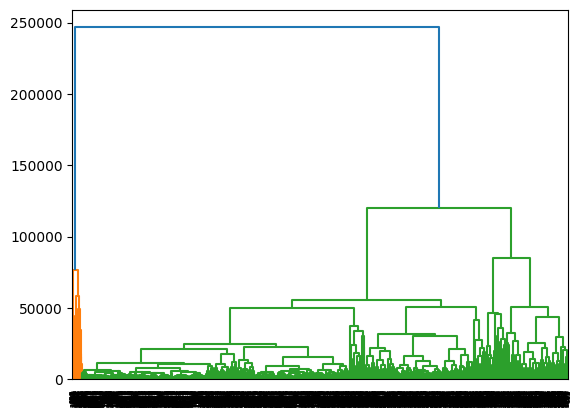

In [ ]:
linked3 = linkage(df_new, method='average')
dendrogram(linked3)
plt.show()

so far we have used different linkages
- 1) Single linkage :
	- The distance between two clusters is defined as the shortest distance between points in the two clusters.
	- Can form elongated or "chained" clusters; sensitive to noise and outliers.

- 2) complete linkage :
	- The distance between two clusters is defined as the longest distance between points in the two clusters.
	- Tends to produce more compact and spherical clusters; less sensitive to noise compared to single linkage.

- 3) average Linkage :
	- The distance between two clusters is defined as the average distance between all pairs of points in the two clusters.
	- Provides a balance between single and complete linkage; results in clusters with relatively similar variance.

- 4) Ward's Linkage :
	- The distance between two clusters is defined as the increase in the total within-cluster variance when the two clusters are merged.
	- Tends to create clusters with similar size and shape; minimizes the variance within each cluster.

  - with that we can , the dendogram with single linkage is completely different and is difficult to find the clusters formed
  - the dendogra with complete linkage considered values and formed two different clusters that are not equally clustered
  - the average is also the same as complete linkage in opposite direction
  - and Ward's Linkage has given clusters with equal importance

In [21]:
df_new.head()

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,flight_miles,flight_trans,Days_since_enroll,Award?,KMeans_Labels
0,28143,0,1,1,1,174,1,0,0,7000,0,1
1,19244,0,1,1,1,215,2,0,0,6968,0,1
2,41354,0,1,1,1,4123,4,0,0,7034,0,1
3,14776,0,1,1,1,500,1,0,0,6952,0,1
4,97752,0,4,1,1,43300,26,2077,4,6935,1,0


In [22]:
df_km=df_new.copy()
df_km.head()

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,flight_miles,flight_trans,Days_since_enroll,Award?,KMeans_Labels
0,28143,0,1,1,1,174,1,0,0,7000,0,1
1,19244,0,1,1,1,215,2,0,0,6968,0,1
2,41354,0,1,1,1,4123,4,0,0,7034,0,1
3,14776,0,1,1,1,500,1,0,0,6952,0,1
4,97752,0,4,1,1,43300,26,2077,4,6935,1,0


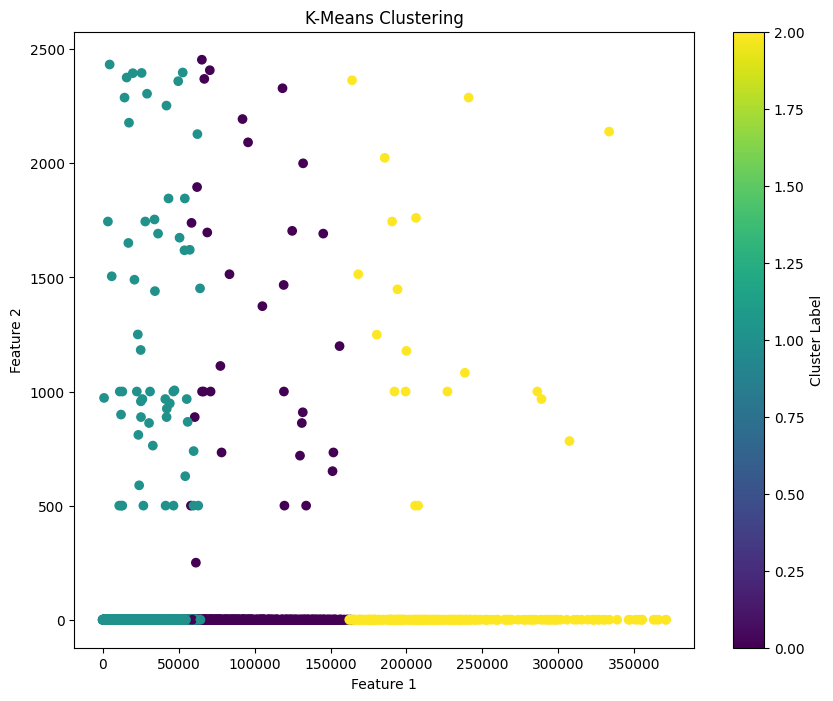

In [23]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_km.iloc[:, 0], df_km.iloc[:, 1], c=df_km['KMeans_Labels'], cmap='viridis')
plt.title('K-Means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(scatter, label='Cluster Label')
plt.show()

### Hierarchical Clustering

In [24]:
df_hc=df_km.drop(columns="KMeans_Labels")
df_hc.head()

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,flight_miles,flight_trans,Days_since_enroll,Award?
0,28143,0,1,1,1,174,1,0,0,7000,0
1,19244,0,1,1,1,215,2,0,0,6968,0
2,41354,0,1,1,1,4123,4,0,0,7034,0
3,14776,0,1,1,1,500,1,0,0,6952,0
4,97752,0,4,1,1,43300,26,2077,4,6935,1


In [25]:
# Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
df_hc['Hierarchical_Labels'] = hierarchical.fit_predict(df_hc)


In [26]:
df_hc.head()

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,flight_miles,flight_trans,Days_since_enroll,Award?,Hierarchical_Labels
0,28143,0,1,1,1,174,1,0,0,7000,0,1
1,19244,0,1,1,1,215,2,0,0,6968,0,1
2,41354,0,1,1,1,4123,4,0,0,7034,0,1
3,14776,0,1,1,1,500,1,0,0,6952,0,1
4,97752,0,4,1,1,43300,26,2077,4,6935,1,0


- See the k means clustering suggested 3 clusters and the hierarchical clustering gave us only 2 clusters i.e. because dendograms are good for only small amount of data giving it large amount of data can be some times mis clustered
- that is why we use dendograms for limited data and k means can be used for large datasets

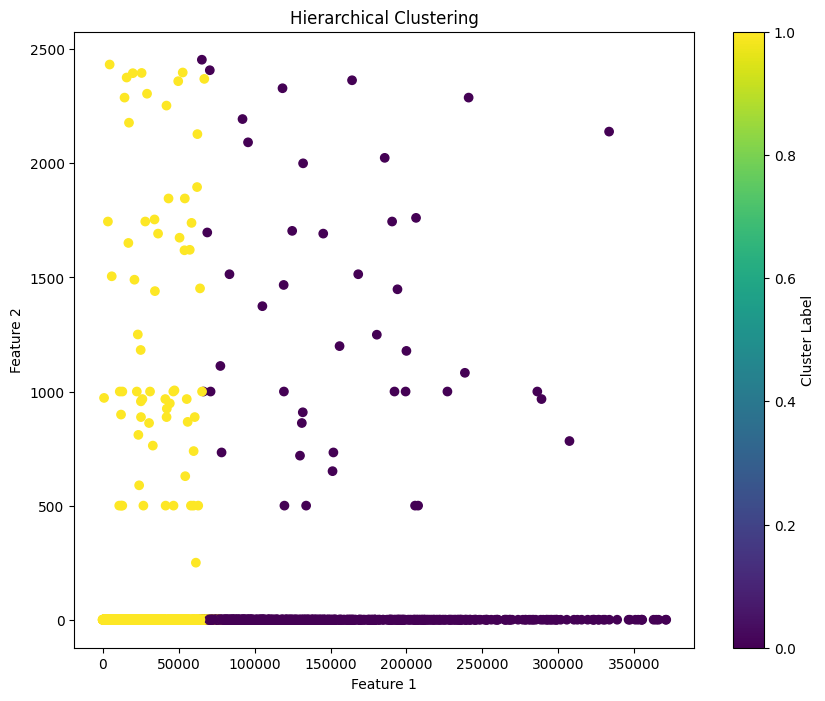

In [27]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_hc.iloc[:, 0], df_hc.iloc[:, 1], c=df_hc["Hierarchical_Labels"], cmap='viridis')
plt.title('Hierarchical Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(scatter, label='Cluster Label')
plt.show()

###DBSCAN

In [28]:
df_DB=df_hc.drop(columns="Hierarchical_Labels",axis=1)
df_DB.head()

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,flight_miles,flight_trans,Days_since_enroll,Award?
0,28143,0,1,1,1,174,1,0,0,7000,0
1,19244,0,1,1,1,215,2,0,0,6968,0
2,41354,0,1,1,1,4123,4,0,0,7034,0
3,14776,0,1,1,1,500,1,0,0,6952,0
4,97752,0,4,1,1,43300,26,2077,4,6935,1


In [42]:
from sklearn.cluster import DBSCAN

# DBSCAN Clustering
dbscan = DBSCAN(eps=0.8, min_samples=2)
df_DB['DBSCAN_Labels'] = dbscan.fit_predict(df_DB)


In [43]:
df_DB.head()

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,flight_miles,flight_trans,Days_since_enroll,Award?,DBSCAN_Labels
0,28143,0,1,1,1,174,1,0,0,7000,0,-1
1,19244,0,1,1,1,215,2,0,0,6968,0,-1
2,41354,0,1,1,1,4123,4,0,0,7034,0,-1
3,14776,0,1,1,1,500,1,0,0,6952,0,-1
4,97752,0,4,1,1,43300,26,2077,4,6935,1,-1


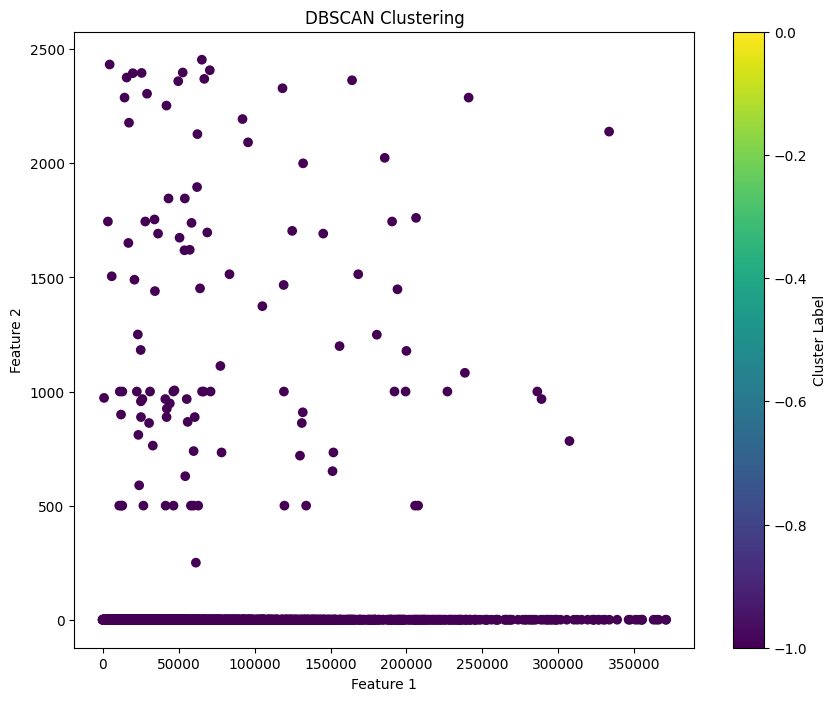

In [44]:
plt.figure(figsize=(10, 8))
plt.scatter(df_DB.iloc[:, 0], df_DB.iloc[:, 1], c=df_DB['DBSCAN_Labels'], cmap='viridis')
plt.title('DBSCAN Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()

In [31]:
df_km.groupby('KMeans_Labels').mean()


,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,flight_miles,flight_trans,Days_since_enroll,Award?
KMeans_Labels,,,,,,,,,,,
0,99311.089231,43.575385,2.784615,1.0,1.0,24502.344615,14.181538,353.880000,1.088205,4565.185641,0.383590
1,25862.688758,31.738255,1.559983,1.0,1.0,8192.479027,8.322987,180.091443,0.563339,3738.162332,0.309983
2,225831.856089,94.250923,3.011070,1.0,1.0,31311.328413,15.926199,570.380074,1.645756,5097.841328,0.450185


In [32]:
df_hc.groupby('Hierarchical_Labels').mean()


,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,flight_miles,flight_trans,Days_since_enroll,Award?
Hierarchical_Labels,,,,,,,,,,,
0,136122.632407,54.986111,2.910185,1.0,1.0,27190.587963,14.887037,412.857407,1.222222,4730.884259,0.408333
1,28499.196863,33.061569,1.610588,1.0,1.0,8839.290588,8.590980,189.434510,0.600000,3778.429412,0.311373


In [45]:
df_DB.groupby('DBSCAN_Labels').mean()

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,flight_miles,flight_trans,Days_since_enroll,Award?
DBSCAN_Labels,,,,,,,,,,,
-1,60552.203693,39.606395,1.997795,1.0,1.0,14307.063396,10.469956,256.048512,0.785557,4063.163175,0.340408
0,1000.000000,0.000000,1.000000,1.0,1.0,0.000000,0.000000,0.000000,0.000000,1597.000000,0.000000


* INTERPRETATIONS
- K Means
  - cluster (0), represents a group with above average activity in all metrics, this group is are consitent and safe canditates
  - cluster (1), represnts a group with low activity compared to cluster (0), and might consists of new or old members
  - cluster (2), represents a group with high activity compared to remaining clusters, and might have vip members are it clearly indicates they won't leave this  airlines and have slightly higher chance of having awards

- Hierarchical Clustering
  - cluster (0), represent a group with high activity in all metrics and have a chance for reward better than the other cluster
  - cluster (1), represent a grup with medium activity in all metrics and have a low chance for rewrad than cluster (0)
- DB SCAN
  - Cluster (0), represents a group with very low activity across all metrics. This group might consist of new or inactive members.
  - Noise points (-1) represent outliers with significantly higher activity levels and engagement, which might indicate VIP or very active customers.

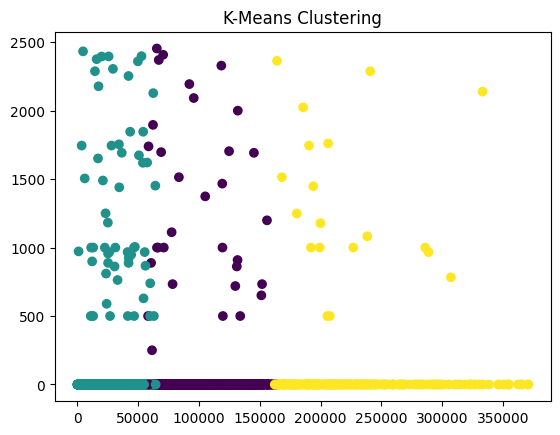

In [46]:
# Scatter Plot for K-Means
plt.scatter(df_km.iloc[:, 0], df_km.iloc[:, 1], c=df_km['KMeans_Labels'])
plt.title('K-Means Clustering')
plt.show()

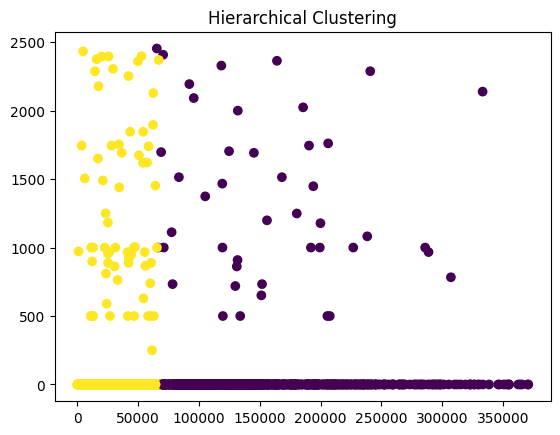

In [47]:
# Scatter Plot for Hierarchical Clustering
plt.scatter(df_hc.iloc[:, 0], df_hc.iloc[:, 1], c=df_hc['Hierarchical_Labels'])
plt.title('Hierarchical Clustering')
plt.show()

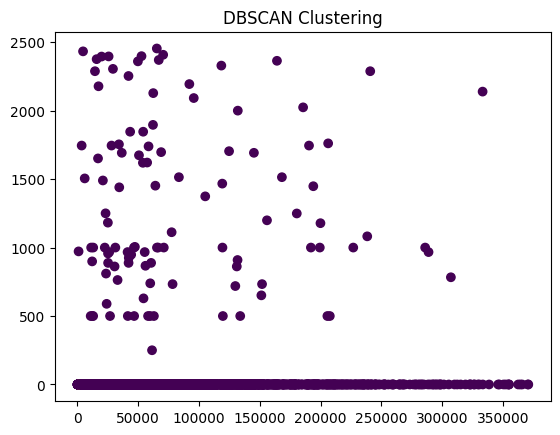

In [48]:
# Scatter Plot for DBSCAN
plt.scatter(df_DB.iloc[:, 0], df_DB.iloc[:, 1], c=df_DB['DBSCAN_Labels'])
plt.title('DBSCAN Clustering')
plt.show()

In [50]:
from sklearn.metrics import silhouette_score

# Silhouette Scores
kmeans_silhouette = silhouette_score(df_km, df_km['KMeans_Labels'])

print(f"K-Means Silhouette Score: {kmeans_silhouette}")

K-Means Silhouette Score: 0.5632800200381382


In [51]:
hierarchical_silhouette = silhouette_score(df_hc, df_hc['Hierarchical_Labels'])

print(f"Hierarchical Silhouette Score: {hierarchical_silhouette}")

Hierarchical Silhouette Score: 0.5943282181838195


In [52]:
dbscan_silhouette = silhouette_score(df_DB, df_DB['DBSCAN_Labels'])

print(f"DBSCAN Silhouette Score: {dbscan_silhouette}")

DBSCAN Silhouette Score: -0.20211591487671468


K-Means Clustering (Silhouette Score: 0.56)
Interpretation:
- The clusters are relatively compact, with data points within clusters being reasonably close to each other.
- The clusters are moderately well-separated, though there might be some overlap between clusters.
- A score of 0.56 indicates that K-Means is performing fairly well, but there is room for improvement.

Hierarchical Clustering (Silhouette Score: 0.59)
Interpretation:

- The score of 0.59 indicates that the clusters are slightly better defined compared to K-Means.
- The data points within each cluster are fairly close to each other, and the clusters are more distinct.
- Hierarchical clustering has the highest silhouette score among the three methods, suggesting it provides the best clustering results for your dataset.

DBSCAN (Silhouette Score: -0.202)
- A negative silhouette score indicates poor clustering quality.
- Data points are either incorrectly clustered or the clusters overlap significantly.
- A negative score suggests that many points might be considered noise or that the chosen parameters are not suitable for the dataset.